link to the colab notebook <br> https://colab.research.google.com/drive/1-hjUWlnQcCemRh0Nh3xHfl_G5Iux7tQS?usp=sharing

# dO NOT RUN ALL

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

## Initializing the biased testset and dataset

In [ ]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}
swapped_colors = {i: digit_colors[(i + 1) % 10] for i in range(10)}
class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95,is_hard=False):
        self.bias_prob = bias_prob
        self.is_hard_set = is_hard

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask
        if self.is_hard_set:
            if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color =  digit_colors[label]
            else:
              base_color = swapped_colors[label]
        else:
          # Choose dominant or random color
          if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color = digit_colors[label]
          else:
              base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [ ]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob,is_hard=False):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob,is_hard=is_hard)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [ ]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95,is_hard=False)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.05,is_hard=True)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.26MB/s]


In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ColorJitter
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2,3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

        self.activations = None  # to store conv features
        self.gradients = None  # for Grad-CAM
    def save_activations(self, x):
        self.activations = x
        return x
    # Hook to save gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.save_activations(x)
        x.requires_grad_(True)
        x.register_hook(self.activations_hook)  # hook here
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def get_activations(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        return x  # feature maps BEFORE final pooling


# upload the weights of the models of Task1_v4.pth given in github under folder /Task6/weights

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Task1_v4.pth to Task1_v4.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = Net().to(device)  # your CNN class
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    return model


In [ ]:
model_biased = load_model("Task1_v4.pth")

print("All models loaded successfully.")


All models loaded successfully.


In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    lambda_consistency = 1
    color_jitter = ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9, hue=0.3)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        optimizer.zero_grad()

        # Color jitter version of inputs
        augmented = torch.stack([color_jitter(img.cpu()) for img in data]).to(device)

        output = model(data)
        output_aug = model(augmented)
        ce_loss = F.nll_loss(output, target)
        consistency_loss = F.mse_loss(output, output_aug)
        loss = ce_loss + lambda_consistency * consistency_loss
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(f"CE: {ce_loss.item():.3f} | Colour loss: {consistency_loss.item():.3f}")
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



## Learning a Sparse Decomposition of Hidden Representations

To understand what the CNN internally encodes, we train a Sparse Autoencoder (SAE) on the Conv2 activations.  
The SAE learns an overcomplete and sparse representation, allowing us to separate hidden activations into independent feature directions.


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, decoder_nonlinearity=False):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.decoder_nonlinearity = decoder_nonlinearity

    def forward(self, x):
        # x: [B, input_dim]
        z = F.relu(self.encoder(x))  # sparse codes non-negative
        x_hat = self.decoder(z)
        if self.decoder_nonlinearity:
            x_hat = F.relu(x_hat)
        return x_hat, z

# KL sparsity penalty between mean activation rho_hat and target rho
def kl_sparsity(rho_hat, rho=0.05):
    # avoid zeros
    rho_hat = torch.clamp(rho_hat, 1e-8, 1-1e-8)
    rho = float(rho)
    term = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    return torch.sum(term)

def train_sae_improved(hidden_data,
                       hidden_multiplier=2,
                       epochs=12,
                       batch_size=256,
                       lr=1e-3,
                       sparsity='l1',          # 'l1' or 'kl' or None
                       sparsity_coeff=1e-3,
                       rho=0.05,
                       device='cuda'):
    """
    hidden_data: torch.Tensor (N, D) on CPU or device
    returns trained sae (on device)
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    X = hidden_data.float().to(device)
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    input_dim = X.shape[1]
    hidden_dim = int(input_dim * hidden_multiplier)
    sae = SparseAutoencoder(input_dim, hidden_dim, decoder_nonlinearity=False).to(device)
    opt = torch.optim.Adam(sae.parameters(), lr=lr)

    for ep in range(epochs):
        epoch_loss = 0.0
        for (batch_x,) in loader:
            batch_x = batch_x.to(device)
            x_hat, z = sae(batch_x)
            recon = F.mse_loss(x_hat, batch_x)

            if sparsity == 'l1':
                spars_loss = torch.mean(torch.abs(z))          # L1 on activations
            elif sparsity == 'kl':
                rho_hat = torch.mean((z > 0).float(), dim=0)  # approximate active probability
                spars_loss = kl_sparsity(rho_hat, rho=rho)
            else:
                spars_loss = torch.tensor(0.0, device=device)

            loss = recon + sparsity_coeff * spars_loss

            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * batch_x.size(0)

        epoch_loss /= len(loader.dataset)
        print(f"[SAE] Epoch {ep+1}/{epochs} loss={epoch_loss:.6f}")

    sae.eval()
    return sae


In [ ]:
def normalize_hidden_data(hidden_data, eps=1e-6):
    # hidden_data: Tensor (N, D)
    mean = hidden_data.mean(dim=0, keepdim=True)
    std  = hidden_data.std(dim=0, keepdim=True)
    std = torch.clamp(std, min=eps)
    return (hidden_data - mean) / std


In [ ]:
def extract_conv2_activations(model, dataset, batch_size=128, max_samples=None):
    model.eval()
    activations = []

    def hook_fn(module, inp, out):
        acts = out.detach().cpu()
        B, C, H, W = acts.shape
        acts = acts.view(B, -1)
        activations.append(acts)

    handle = model.conv2.register_forward_hook(hook_fn)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    count = 0
    with torch.no_grad():
        for imgs, _ in loader:
            model(imgs.to(device))
            count += imgs.size(0)
            if max_samples and count >= max_samples:
                break

    handle.remove()
    hidden_data = torch.cat(activations, dim=0)
    if max_samples:
        hidden_data = hidden_data[:max_samples]
    print("Hidden data shape:", hidden_data.shape)
    return hidden_data

 # Run the following 2 blocks to load the Sparse autoencoder. make sure the upload name is sae_model.pt given under Task4/weights

In [ ]:
# 1) extract a subset, normalize
hidden_raw = extract_conv2_activations(model=model_colorloss, dataset=train_easy, batch_size=256, max_samples=5000)
hidden = normalize_hidden_data(hidden_raw)   # returns CPU tensor

Hidden data shape: torch.Size([5000, 600])


In [ ]:
uploaded = files.upload()

Saving sae_model.pt to sae_model.pt


In [ ]:
checkpoint = torch.load("sae_model.pt", map_location=device)

sae = SparseAutoencoder(
    input_dim=checkpoint['input_dim'],
    hidden_dim=checkpoint['hidden_dim']
).to(device)

sae.load_state_dict(checkpoint['model_state_dict'])
sae.eval()

print("SAE model loaded successfully!")


SAE model loaded successfully!


# DO NOT RUN THE BELOW BLOCK! its only for initial training

In [ ]:


# 2) quick SAE
sae = train_sae_improved(hidden, hidden_multiplier=2, epochs=10, batch_size=512, lr=1e-3,
                         sparsity='l1', sparsity_coeff=1e-3, device=device)


[SAE] Epoch 1/10 loss=0.524024
[SAE] Epoch 2/10 loss=0.204305
[SAE] Epoch 3/10 loss=0.130009
[SAE] Epoch 4/10 loss=0.093343
[SAE] Epoch 5/10 loss=0.073074
[SAE] Epoch 6/10 loss=0.060394
[SAE] Epoch 7/10 loss=0.051757
[SAE] Epoch 8/10 loss=0.045613
[SAE] Epoch 9/10 loss=0.040777
[SAE] Epoch 10/10 loss=0.036907


## Visualizing Learned SAE Features

Each neuron in the SAE corresponds to a direction in the hidden activation space.  
By reshaping the encoder weights, we can visualize which spatial regions of the Conv2 feature maps each SAE feature is sensitive to.


In [ ]:
def visualize_decoder_feature(sae, feature_idx, conv_shape, cmap='inferno'):
    weights = sae.decoder.weight.data.cpu()
    w = weights[:, feature_idx]
    C, H, W = conv_shape
    fmap = w.view(C, H, W).mean(0)
    plt.imshow(fmap, cmap=cmap)
    plt.title(f"Decoder feature {feature_idx}")
    plt.colorbar()
    plt.show()


In [ ]:
def get_codes_and_labels(sae, model, dataset, batch_size=128, max_samples=None):
    model.eval(); sae.eval()
    codes = []
    digits = []
    colors = []
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    count = 0
    for imgs, labs in loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            x = F.relu(model.conv1(imgs))
            x = F.max_pool2d(x,2)
            conv2 = F.relu(model.conv2(x))
            flat = conv2.view(conv2.size(0), -1)
            _, z = sae(flat)
            codes.append(z.cpu())
            digits.append(labs)
            imgs_cpu = imgs.cpu()
            mean_rgb = imgs_cpu.view(imgs_cpu.size(0), 3, -1).mean(dim=2)  # B x 3
            colors.append(mean_rgb)
        count += imgs.size(0)
        if max_samples and count >= max_samples:
            break

    codes = torch.cat(codes, dim=0)
    digits = torch.cat(digits, dim=0)
    colors = torch.cat(colors, dim=0)
    return codes, digits, colors

from sklearn.linear_model import LogisticRegression
def linear_probe(codes, labels, test_frac=0.2, random_state=0):
    X = codes.numpy()
    y = labels.numpy()
    n = len(y)
    idx = np.arange(n)
    np.random.seed(random_state)
    np.random.shuffle(idx)
    split = int(n*(1-test_frac))
    Xtr, Xte = X[idx[:split]], X[idx[split:]]
    ytr, yte = y[idx[:split]], y[idx[split:]]
    clf = LogisticRegression(max_iter=200, multi_class='multinomial', solver='saga').fit(Xtr, ytr)
    acc = clf.score(Xte, yte)
    return acc

codes, digits, colors = get_codes_and_labels(sae, model_biased, train_easy, max_samples=3000)
digit_acc = linear_probe(codes, digits)
print("Digit probe accuracy on SAE codes:", digit_acc)
ref_colors = torch.stack([digit_colors[i].float() for i in range(10)])  # shape 10 x 3
color_labels = []
for v in colors:
    dists = torch.norm(ref_colors - v, dim=1)
    color_labels.append(torch.argmin(dists).item())
color_labels = torch.tensor(color_labels)
color_acc = linear_probe(codes, color_labels)
print("Color probe accuracy on SAE codes:", color_acc)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Digit probe accuracy on SAE codes: 0.9804878048780488
Color probe accuracy on SAE codes: 0.9414634146341463


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
def visualize_decoder_feature(sae, feature_idx, conv_shape, cmap='inferno'):
    """
    Visualize what an SAE feature has learned in spatial conv space
    """
    with torch.no_grad():
        W = sae.decoder.weight.data.cpu()  # (input_dim, hidden_dim)
        w = W[:, feature_idx]              # (input_dim,)
        C, H, Wd = conv_shape
        fmap = w.view(C, H, Wd).mean(0)    # average over channels

    plt.figure(figsize=(4,4))
    plt.imshow(fmap, cmap=cmap)
    plt.title(f"SAE Feature {feature_idx} (decoder map)")
    plt.colorbar()
    plt.axis('off')
    plt.show()


In [ ]:
dummy = torch.randn(1,3,28,28).to(device)
with torch.no_grad():
    x = F.relu(model_biased.conv1(dummy))
    x = F.max_pool2d(x, 2)
    x = F.relu(model_biased.conv2(x))
print(x.shape)  # => (1, C, H, W)
conv_shape = (x.shape[1], x.shape[2], x.shape[3])


torch.Size([1, 24, 5, 5])


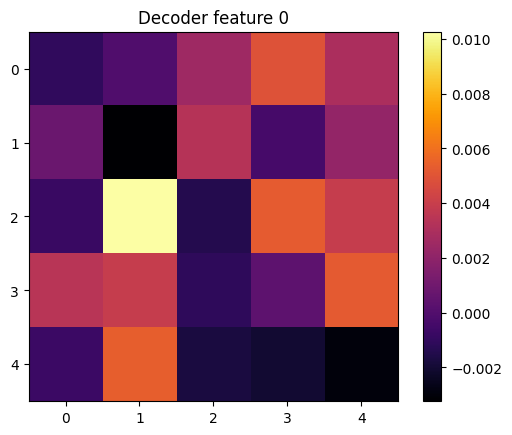

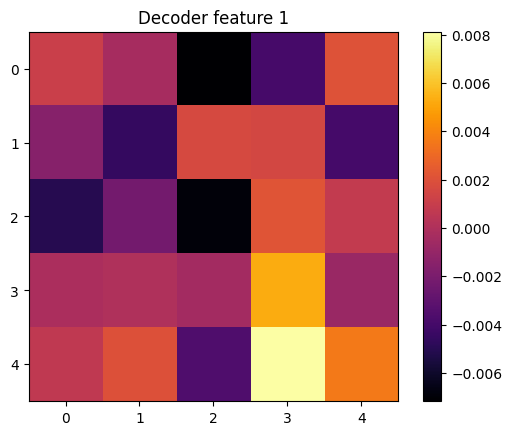

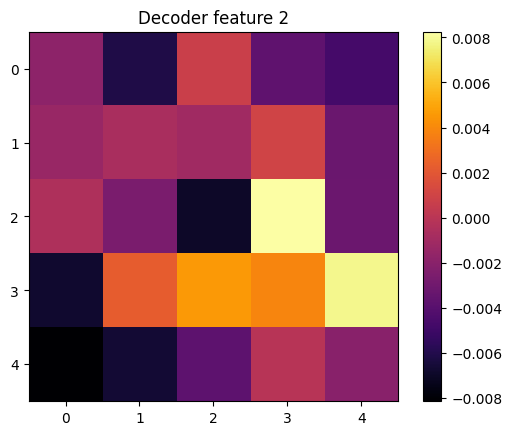

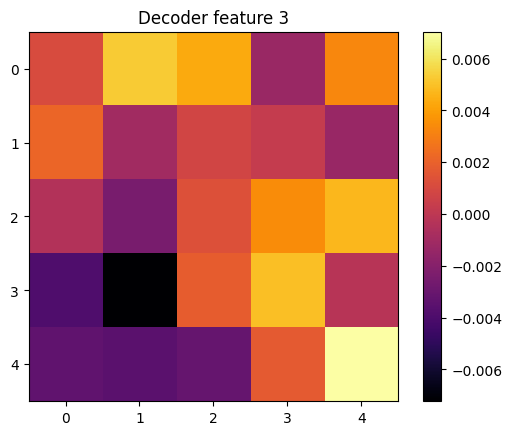

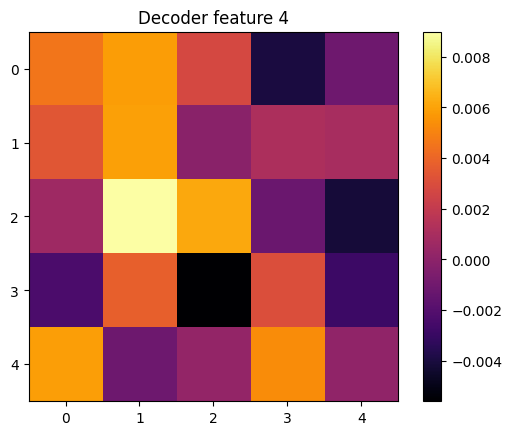

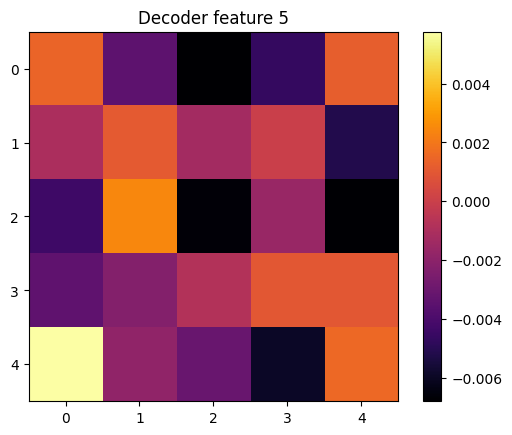

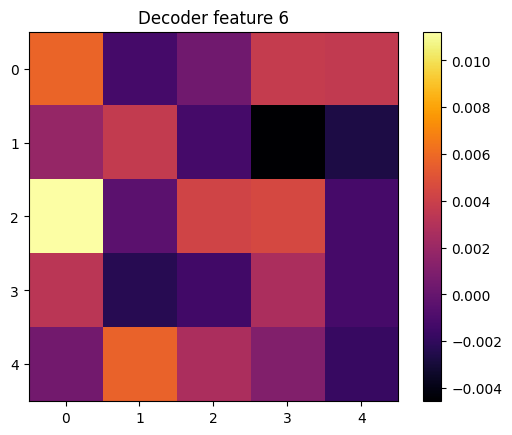

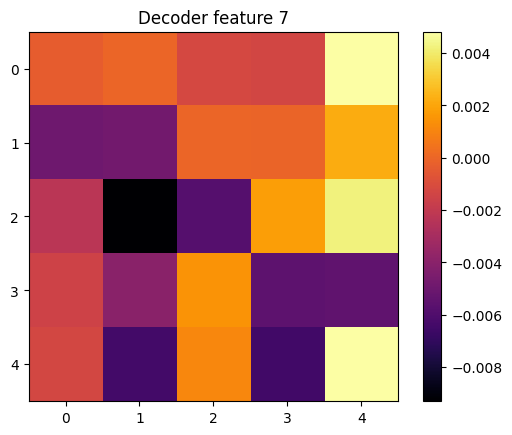

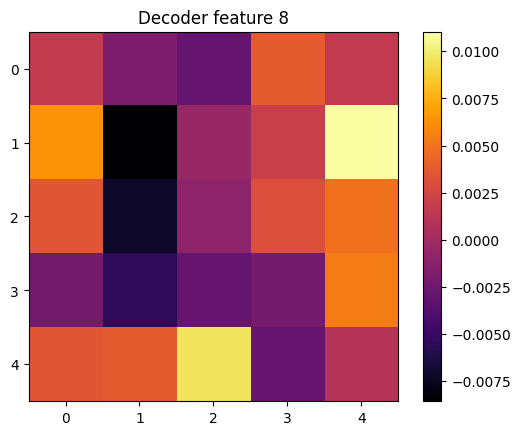

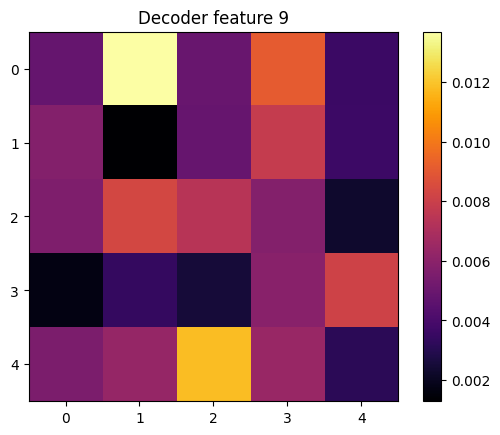

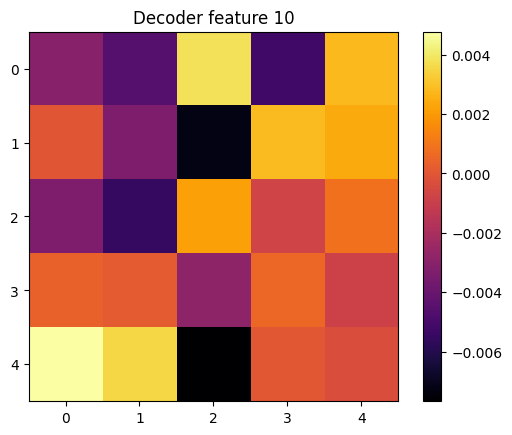

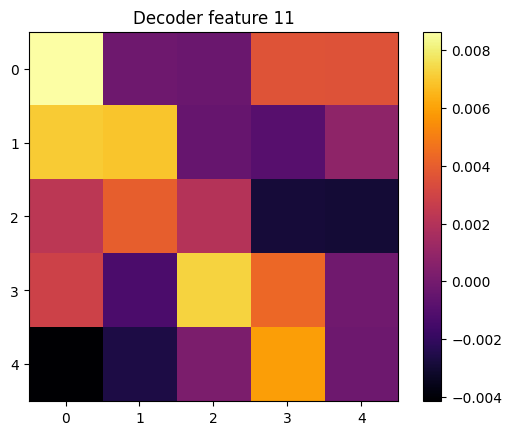

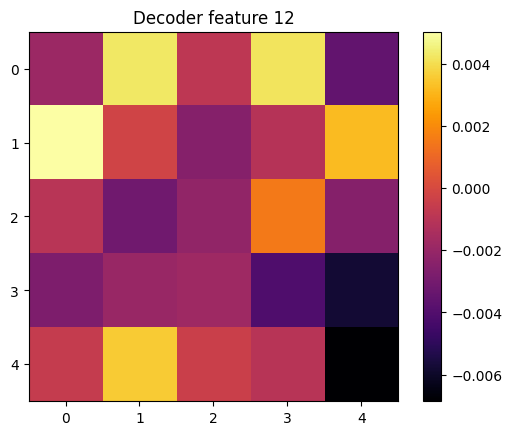

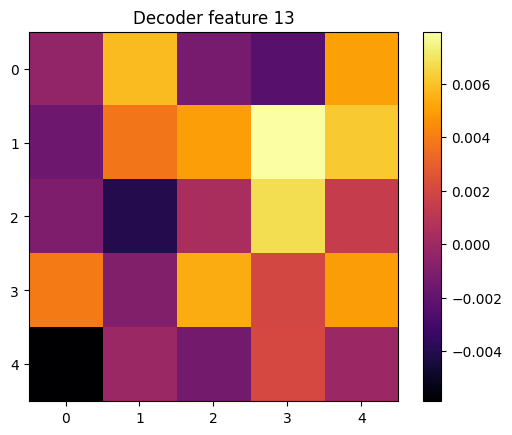

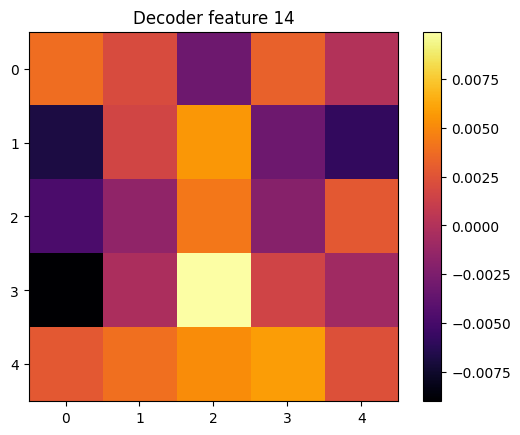

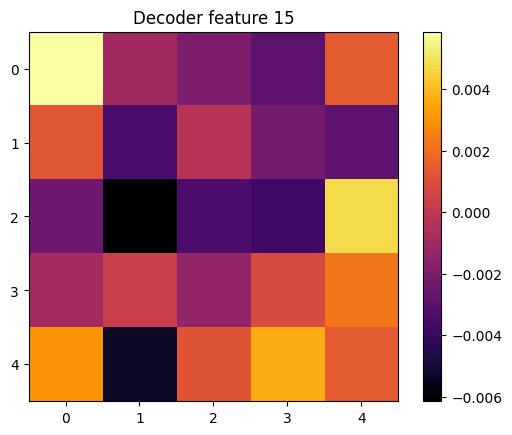

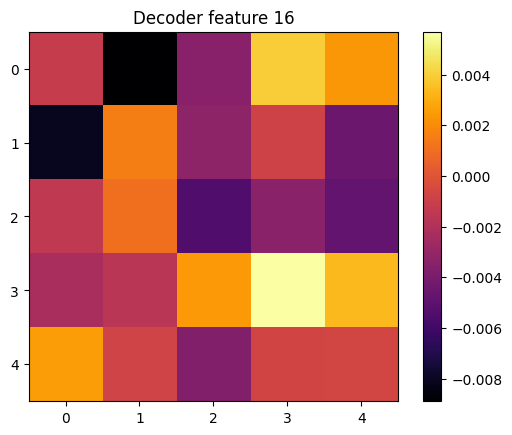

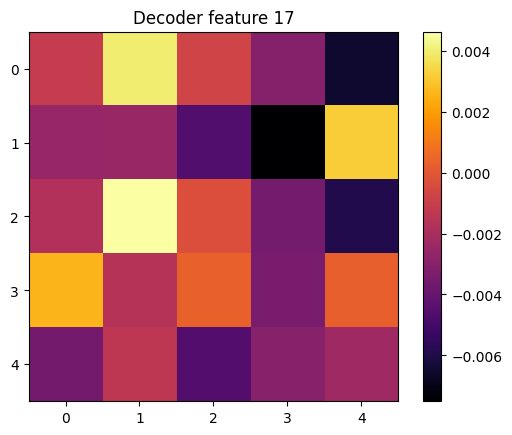

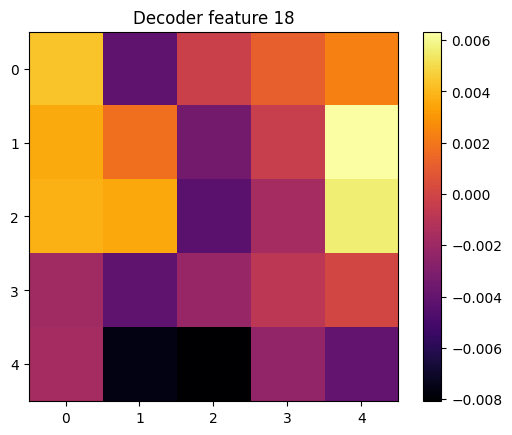

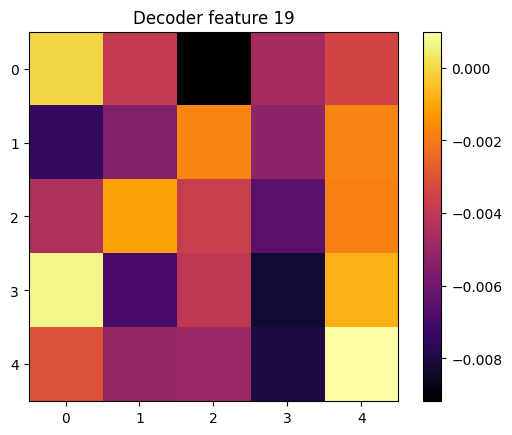

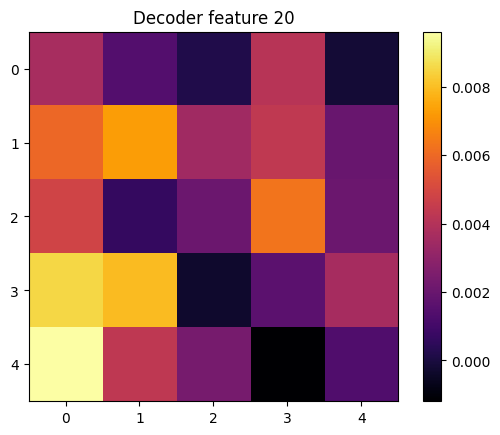

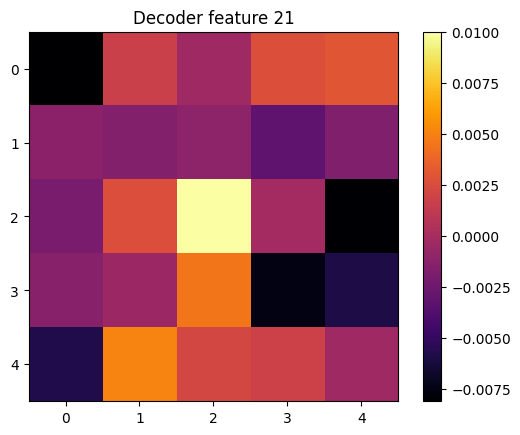

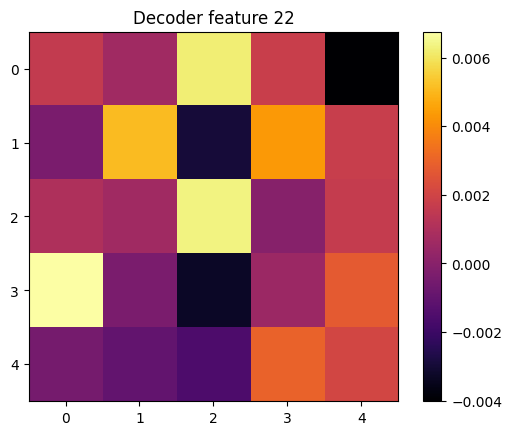

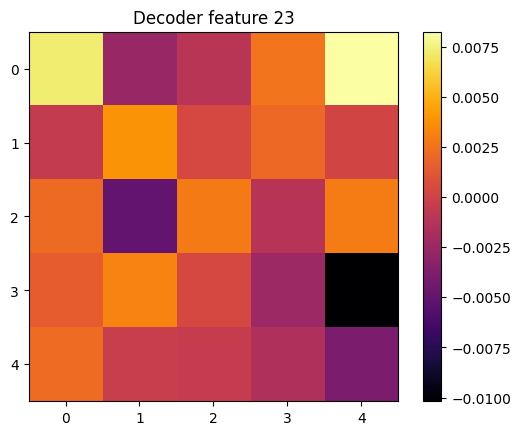

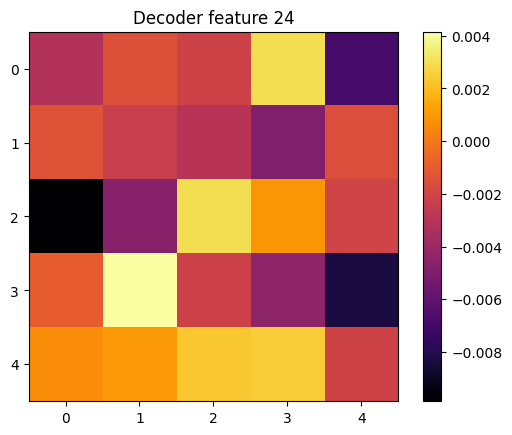

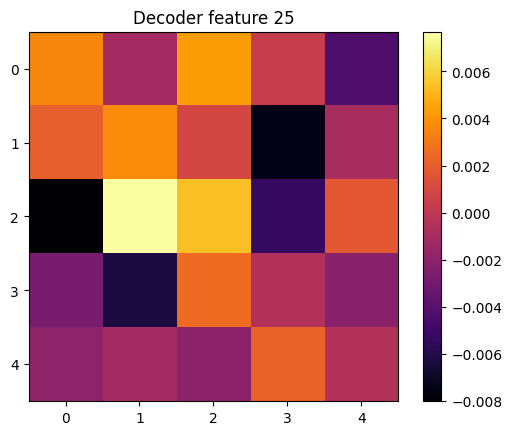

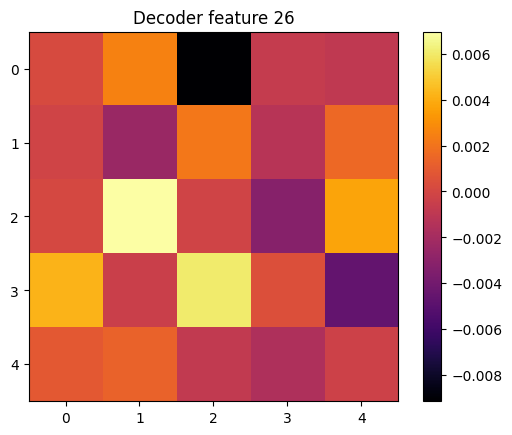

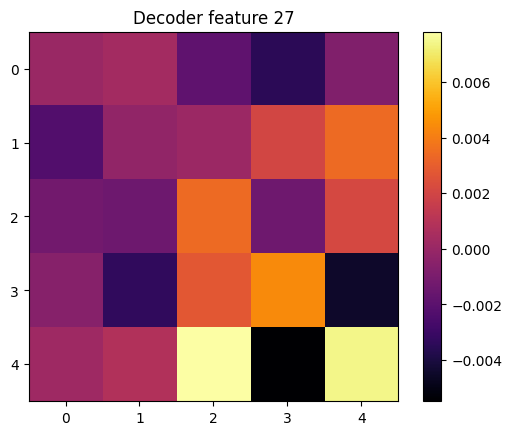

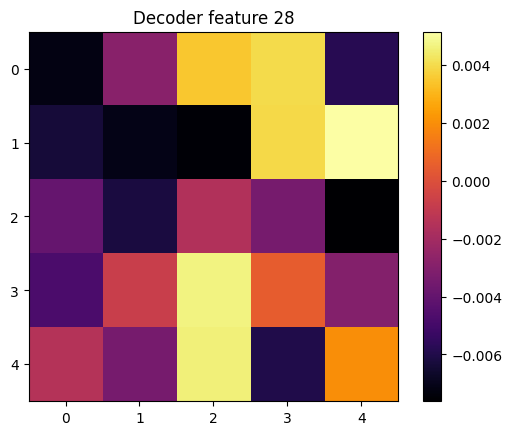

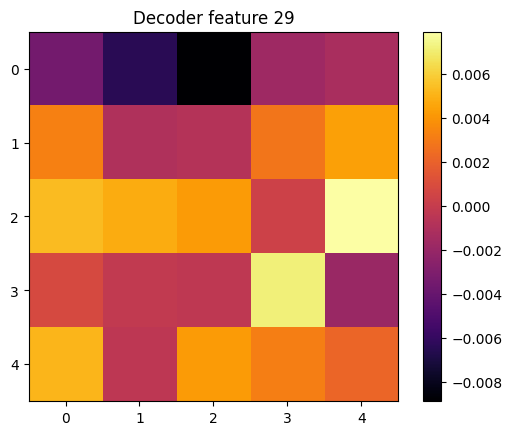

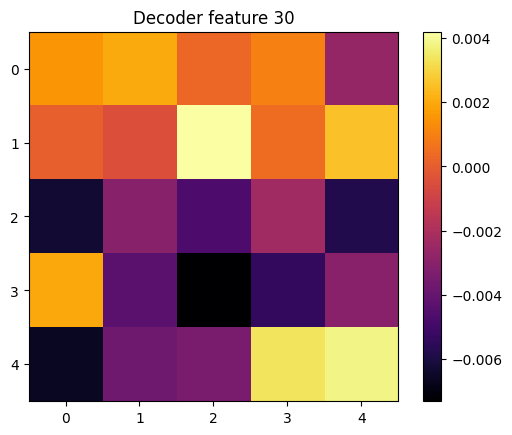

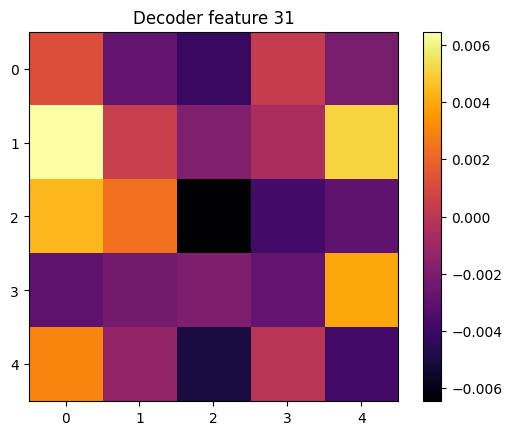

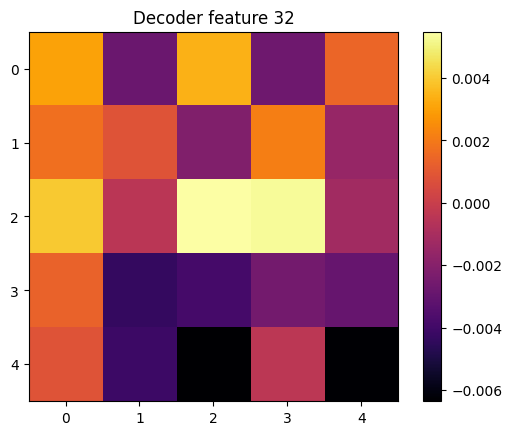

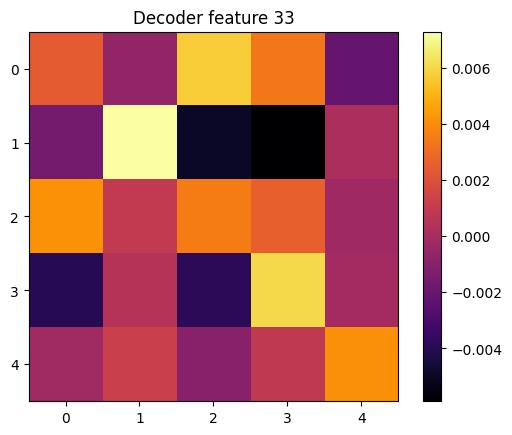

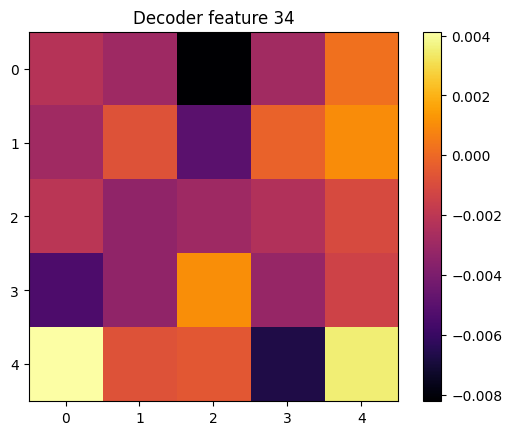

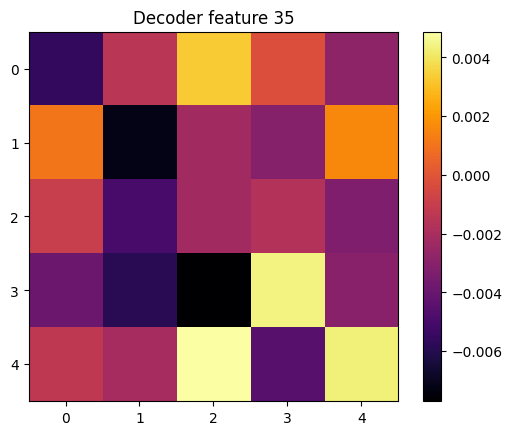

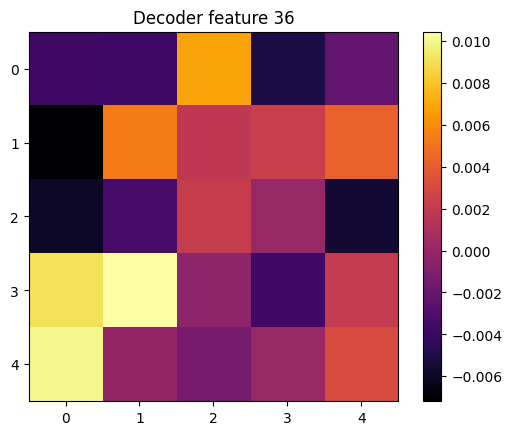

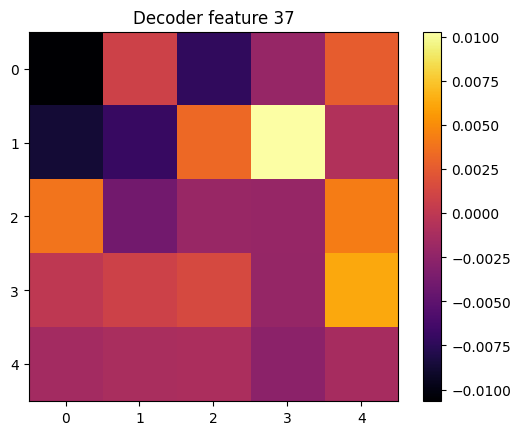

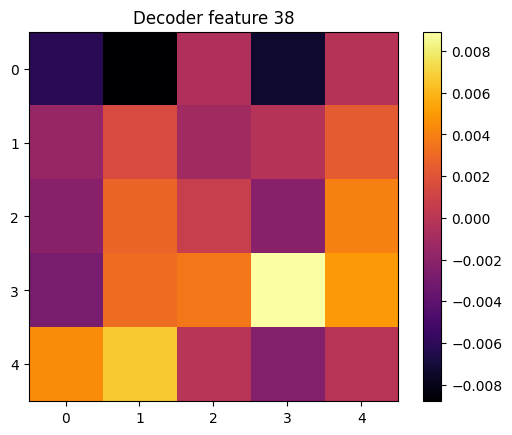

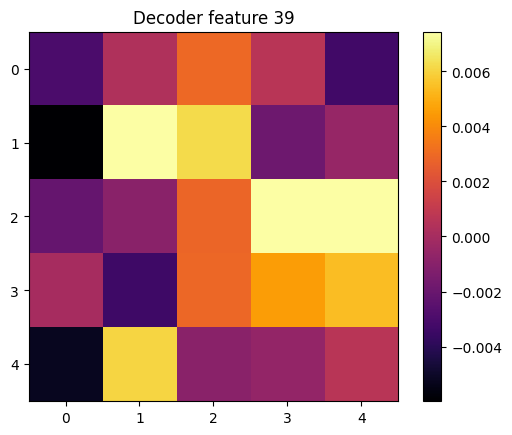

In [ ]:
for i in range(40):
    visualize_decoder_feature(sae, i, conv_shape)


## Finding Images That Activate Each SAE Feature

To interpret what each SAE feature represents, we find the images that produce the strongest activations for that feature.  
This helps us determine whether a feature encodes color, shape, or a mixture of both.


In [ ]:
def visualize_top_activating_images(sae, model, dataset, feature_idx, top_k=7):
    model.eval(); sae.eval()
    activations = []
    images = []

    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            x = F.relu(model.conv1(imgs))
            x = F.max_pool2d(x,2)
            conv2 = F.relu(model.conv2(x))
            flat = conv2.view(conv2.size(0), -1)
            _, z = sae(flat)
            activations.append(z[:, feature_idx].cpu())
            images.append(imgs.cpu())

    activations = torch.cat(activations)
    images = torch.cat(images)

    top_idx = torch.topk(activations, top_k).indices

    plt.figure(figsize=(12,3))
    for i, idx in enumerate(top_idx):
        plt.subplot(1, top_k, i+1)
        img = images[idx].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.title(f"{activations[idx]:.2f}")
        plt.axis('off')
    plt.suptitle(f"Top {top_k} images activating SAE feature {feature_idx}")
    plt.show()


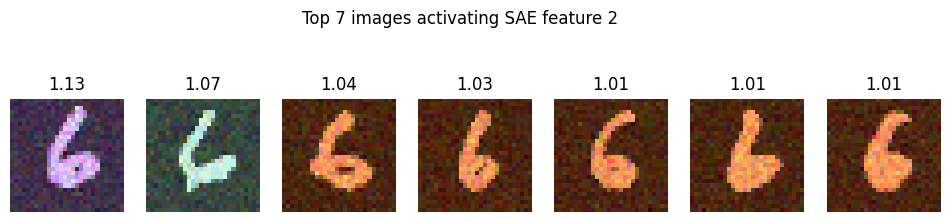

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,2)

## SAE feature 2 can be labelled "central hole + right strike" as the activation map indicates as well as top activation images being 6 of various colours and following this convention<br> 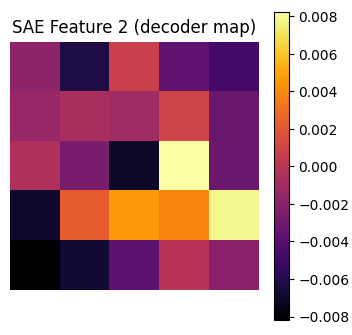

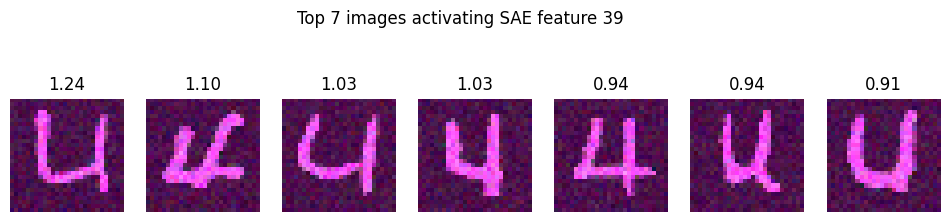

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,39)

SAE feature 39 can be labelled as "pink extension stroke of a 4"
<br>
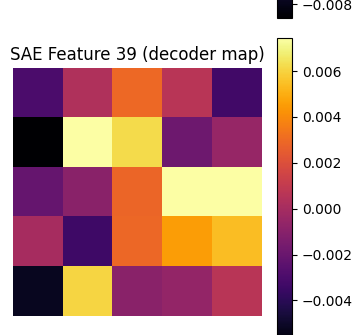

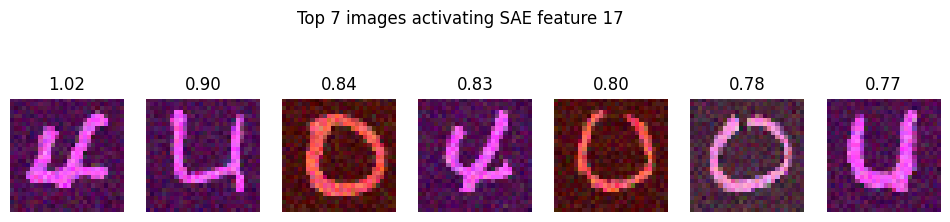

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,17)

SAE feature 17 can be labelled as "pink/red stroke on center left" <br>
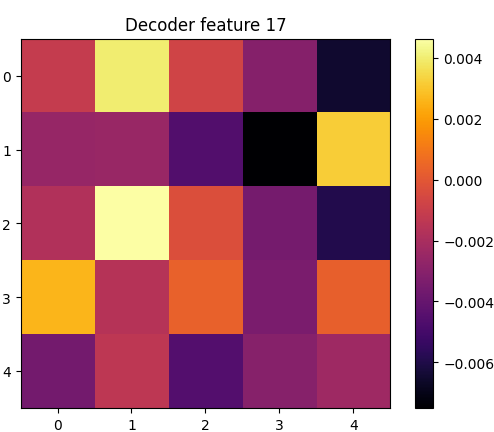

## below are some SAE features i coulnt come up with an label

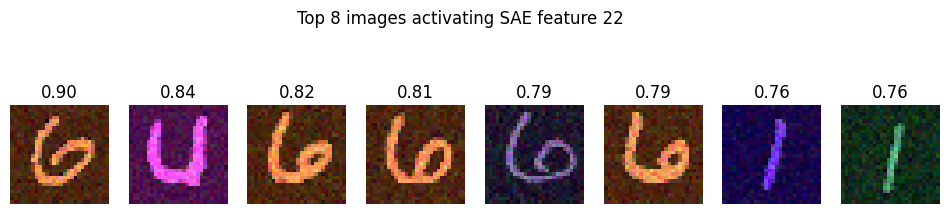

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,22)

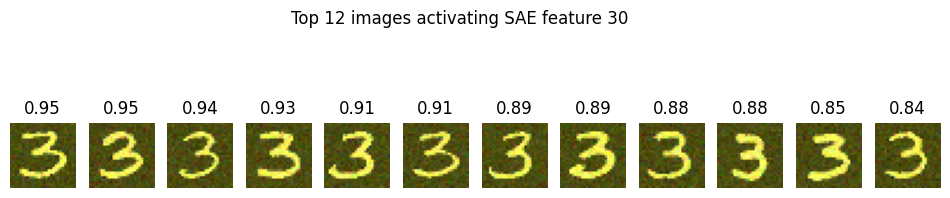

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,30,12)

SAE

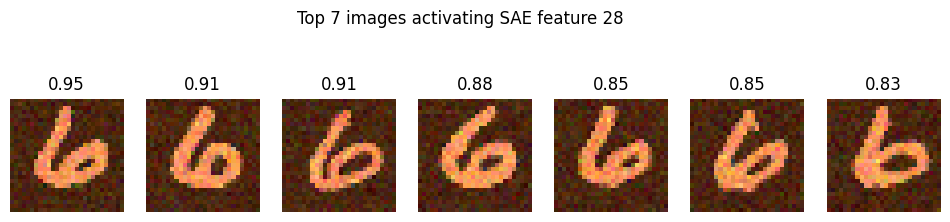

In [ ]:
visualize_top_activating_images(sae,model_colorloss,train_easy,28)

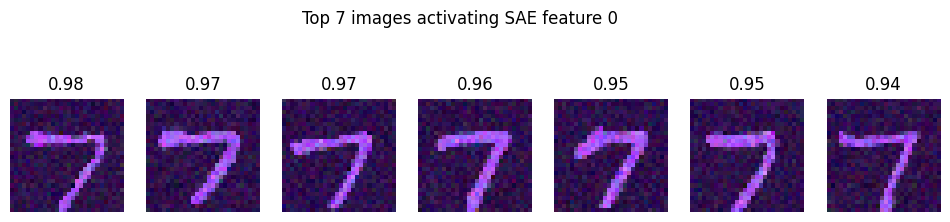

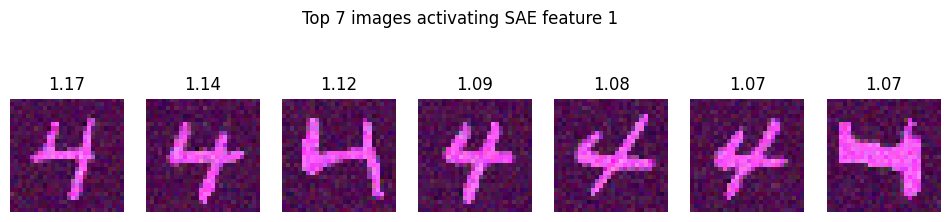

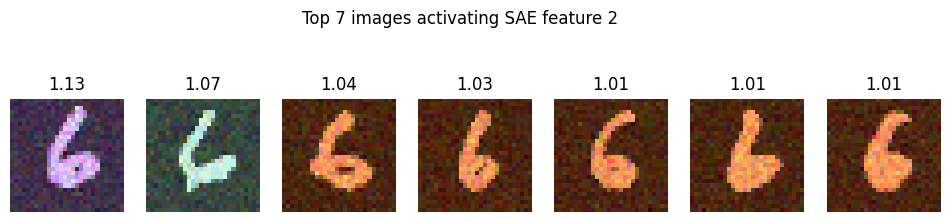

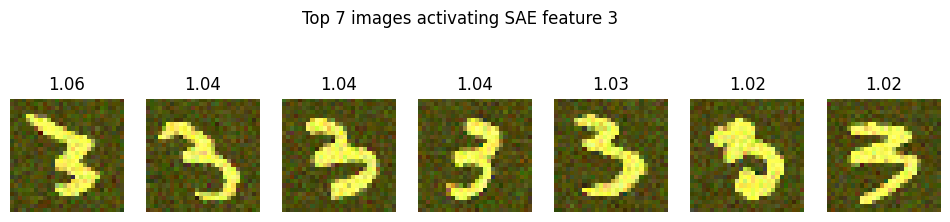

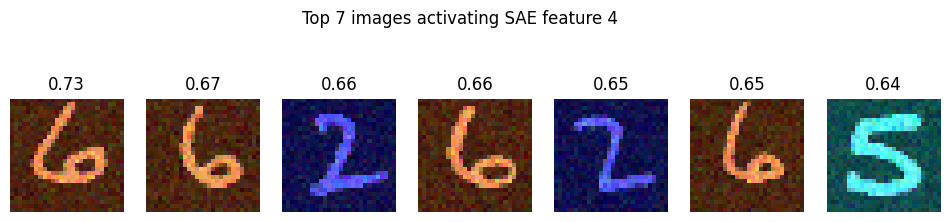

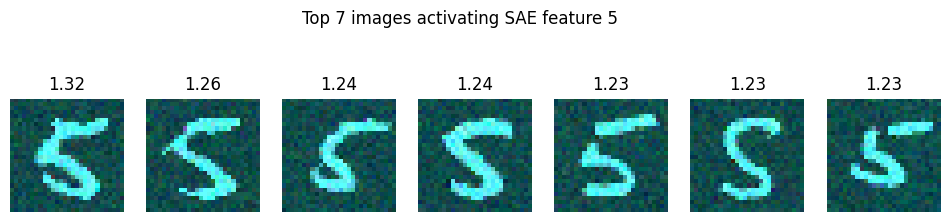

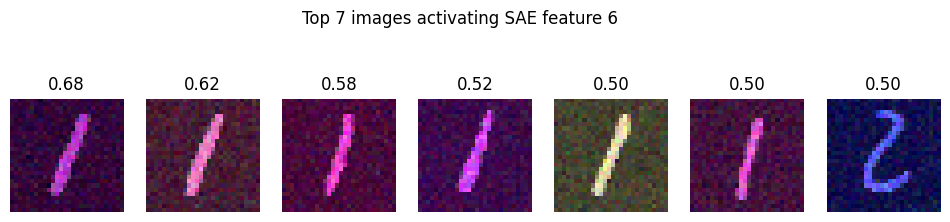

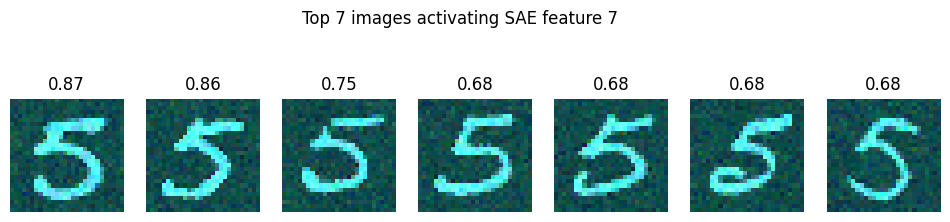

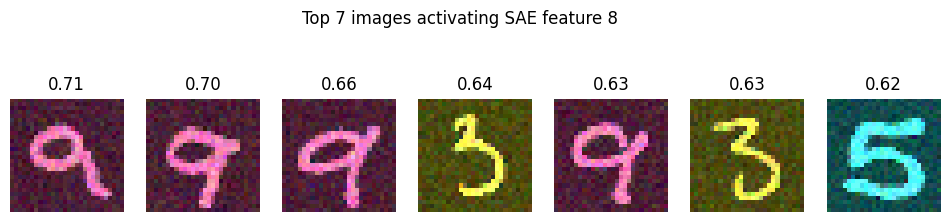

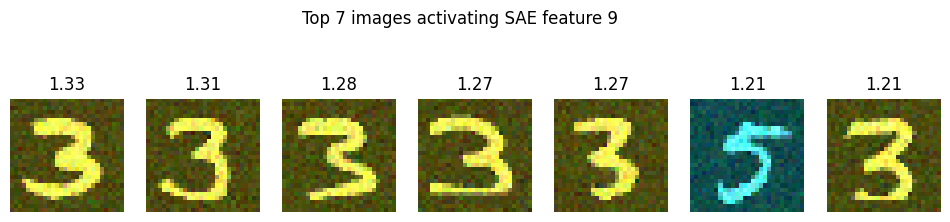

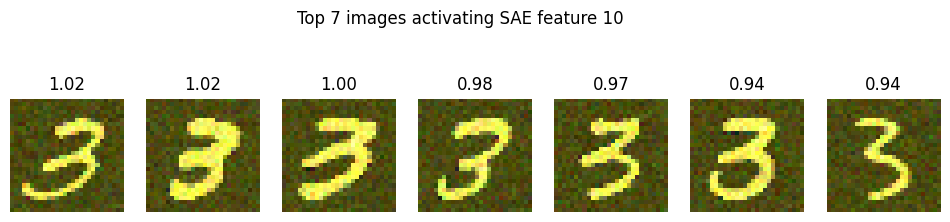

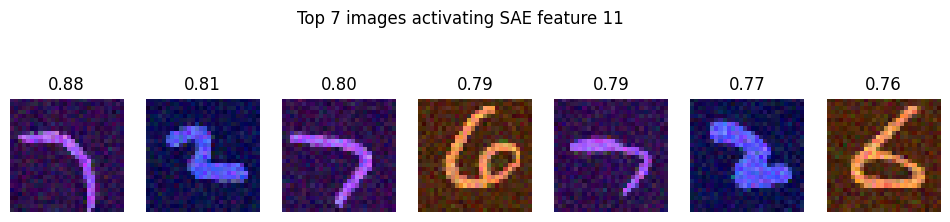

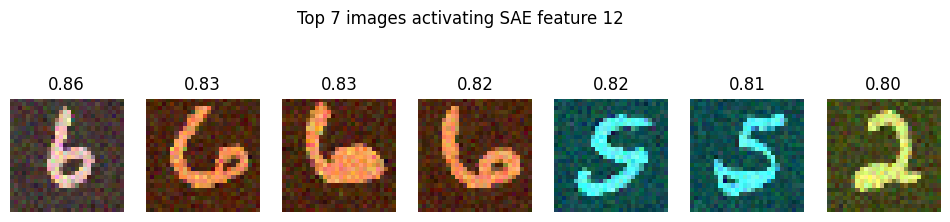

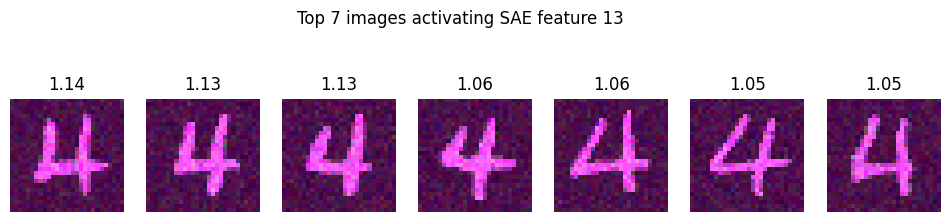

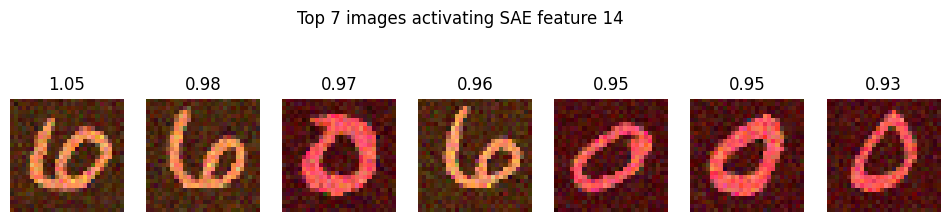

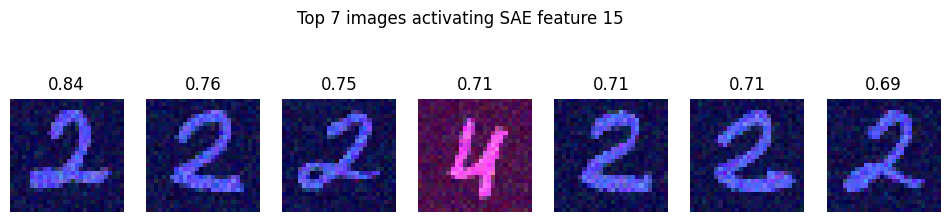

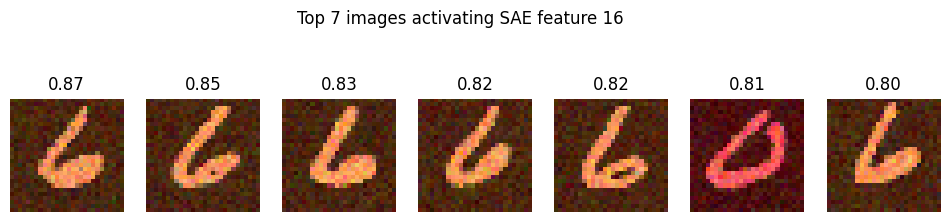

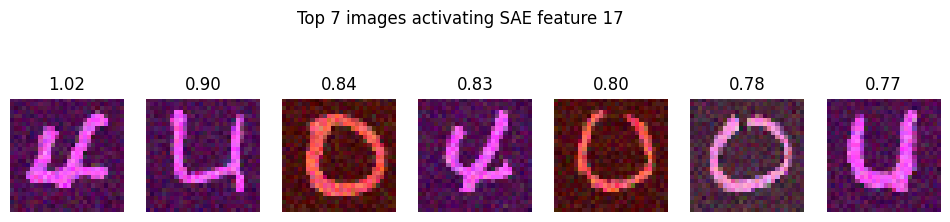

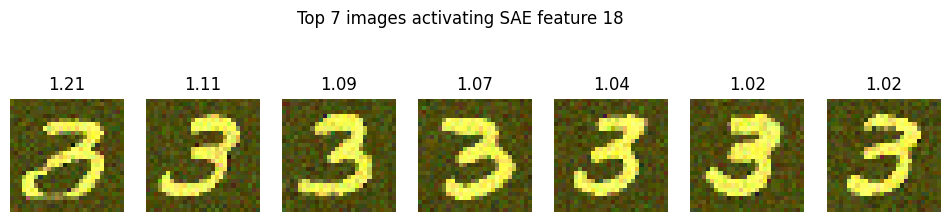

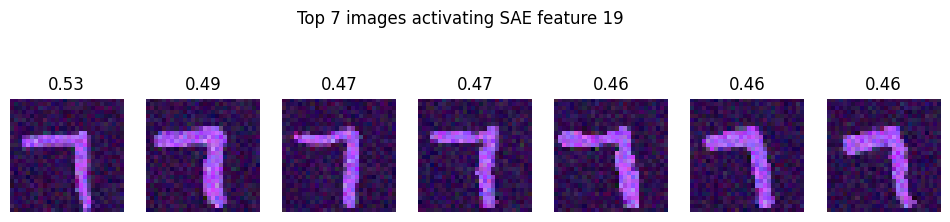

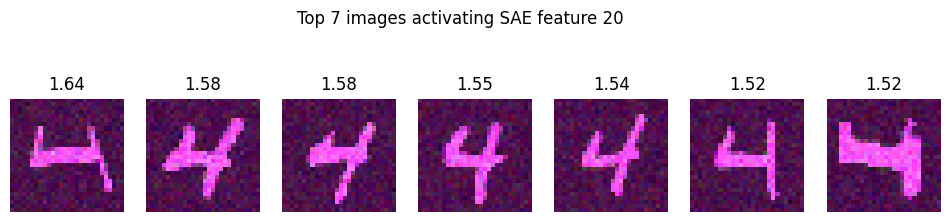

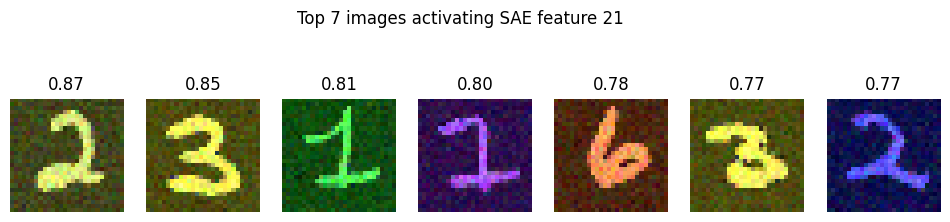

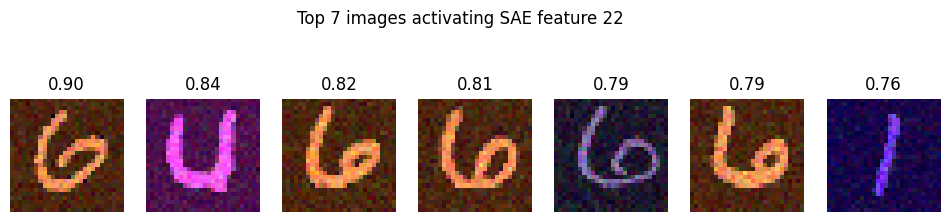

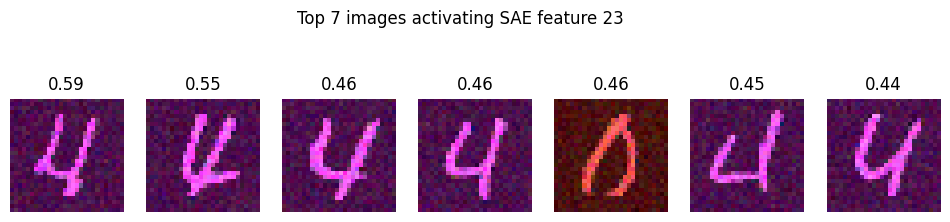

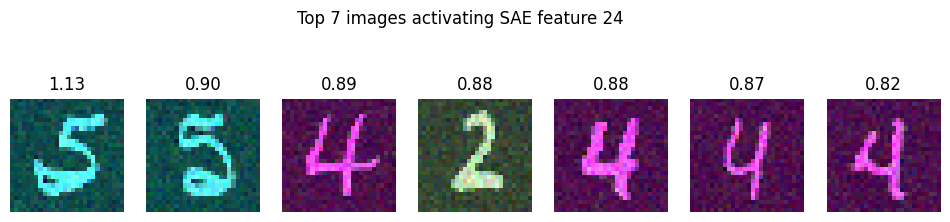

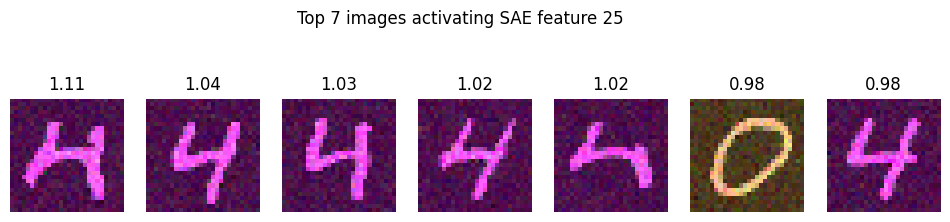

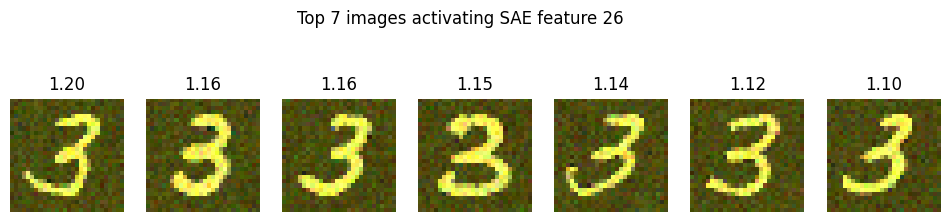

KeyboardInterrupt: 

In [ ]:
for i in range(40):
  visualize_top_activating_images(sae,model_colorloss,train_easy,i)

In [ ]:
torch.save({
    'model_state_dict': sae.state_dict(),
    'input_dim': sae.encoder.in_features,
    'hidden_dim': sae.encoder.out_features
}, "sae_model.pt")

print("SAE model saved!")


SAE model saved!
